## **Overview**
This notebook is "inspired" from the work in the paper "[COVID-19 Chest X-Ray Image Classification Using Deep Learning
](https://https://www.medrxiv.org/content/10.1101/2021.07.15.21260605v1)‬" by Gunther Correia Bacellar, Mallikarjuna Chandrappa, Rajlakshman Kulkarni and Soumava Dey. The idea of this paper is to develop a new convolutional neural network (CNN) for image classification exercise. This paper achieved an overall classification accuracy of 96% in detection of COVID-19 from chest X-ray images when compared to images of both pneumonia-affected and healthy individuals.

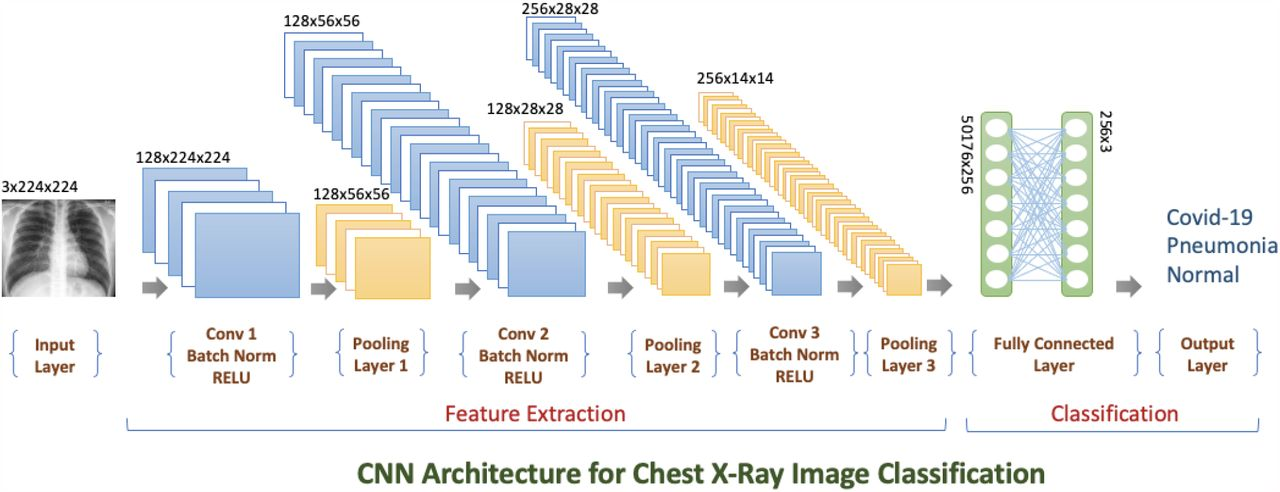
- Schematic of DLH_COVID model architecture. It consists of three convolutional layers, two fully connected linear layers and additional 
intermediate maxpool layers. Input dimension of the CNN network: 3 x 224 x 224 and output dimension of the CNN network: 256 x 3.

## **Objective of the Notebook**

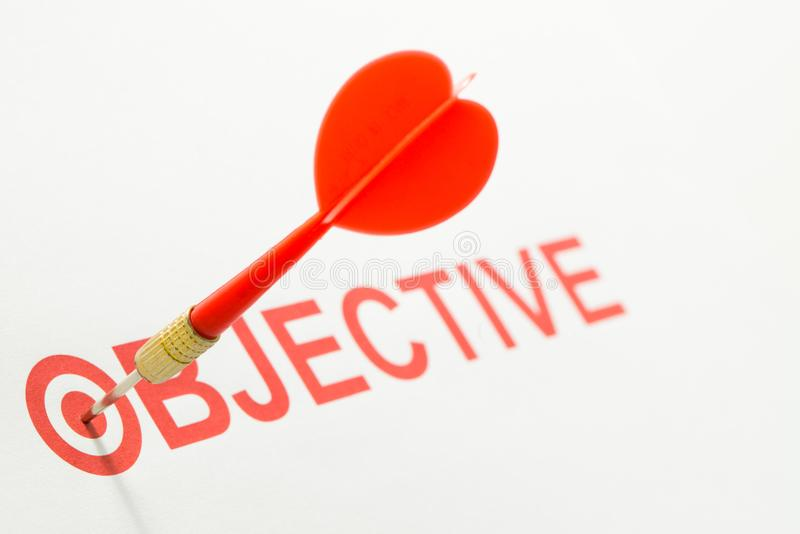

We choose covid-19 detection problem for our graduation project and we will use the paper that we mention it above as a reference,so In this notebook 
- We will implement the DLH_COVID model. 
- Compare it with the other commen models.
- Try to enhance the accuarcy by solving the problems that the authors faced it.

In [ ]:
!pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **1. Import Libraries**

In [ ]:
import os
import time
import cv2
import random
import seaborn as sns 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models
from torch import optim
from sklearn.metrics import *
from PIL import Image
import shutil
import zipfile
import math
from pathlib import Path
# import splitfolders
# which denotes the number of processes that generate batches in parallel.
num_workers = 2 #change this parameter based on your system configuration
# which denotes the number of samples contained in each generated batch.
batch_size = 32 #change this parameter based on your system configuration
seed = 24
random.seed(seed)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
categories = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = len(categories)
splits = ['train', 'val', 'test']
#DATA_PATH =  #Insert data path name
#MODEL_PATH = #Insert model path name

### **1.1 Libraries explaination**
- **os**
  - This module provides a portable way of using operating system dependent functionality.
- **cv2**
  - It mainly focuses on image processing, video capture and analysis including features like face detection and object detection.
- **random**
  - This module implements pseudo-random number generators for various distributions.
- **seaborn**
  - Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.
- **torch**
  - It supports computations of tensors on Graphical Processing Units.
- **numpy**
  - It is a library consisting of multidimensional array objects and a collection of routines for processing of array.
- **matplotlib.pyplot**
  - It is a plotting library for the Python programming language and its numerical mathematics extension NumPy.
- **pandas**
  - it offers data structures and operations for manipulating numerical tables and time series.informative statistical graphics.
- **torch.optim**
  - It is a package implementing various optimization algorithms.
- **torch.nn**
  - It is a base class used to develop all neural network models.
- **torchvision**
  - It is package consists of popular datasets, model architectures, and common image transformations for computer vision.
- **torchvision.datasets**
  - It is a convenient utility for accessing well-known public image and video datasets.
- **torchvision.transforms**
  - Transforms are common image transformations.
- **models**
  - It contains definitions of models for addressing different tasks, including: image classification, object detection, instance segmentation, person keypoint detection and video classification.
- **sklearn.metrics**
  - It implements several loss, score, and utility functions to measure classification performance.
- **PIL.Image**
  - It adds support for opening, manipulating, and saving many different image file formats.
- **shutil**
  - It offers a number of high-level operations on files and collections of files.
- **keras_ocr**
  - It provides out-of-the-box OCR models and an end-to-end training pipeline to build new OCR models.

## **2. Load data from external source**

There are two ways to load data and I will explain them

1. Download the dataset from external datasource.
2. Load Kaggle Datasets Directly into Google Colab.
- so our source here is :
https://www.kaggle.com/prashant268/chest-xray-covid19-pneumonia

**Note :** we will use the second way to laod data, but you have to know that Kaggle host two types of datasets: Competitions and Datasets. The procedure to download any type remains the same with just minor changes, so we here work with the second type (Datasets).

### **2.1. Download the dataset (archive.zip) from external datasource**

#### **Unzip the archieve.zip dataset downloaded from Kaggle**

Downloaded zip file from Kaggle includes folders with x-ray images distributed as train (80%) and test (20%) datasets.

Follow these steps for uploading the dataset to Google Colab environment:

1.   Upload the archive.zip to google drive and mount the drive in Colab 
2.   Copy the zip file from mount drive to Colab folder
1.   Unzip the file
2.   Set the data path to unzipped file location


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##1. Local machine
# Train and test folders will be created inside the DATA_PATH(local machine)

##zip_file = #Assign the file path where zip file downloaded
#with ZipFile(zip_file, 'r') as zipObj:
   #zipObj.extractall(os.path.dirname(zip_file))

##2. Google Colab
# To create Train and test folders inside the Google Colab DATA_PATH
# !cp '/content/drive/MyDrive/chest-xray-covid19-pneumonia.zip' '/content'
# local_zip = '/content/chest-xray-covid19-pneumonia.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/content')
# zip_ref.close()

### **2.2. Load Kaggle Datasets Directly into Google Colab**
Follow these steps to load the datasets directly from Kaggle to Google Colab.
1. Select any dataset from Kaggle
2. Download API Credentials (API token)
3. Setup the Colab Notebook
4. Download datasets
- for more information you should visit this [link](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/)

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download prashant268/chest-xray-covid19-pneumonia

100% 2.05G/2.06G [00:37<00:00, 48.9MB/s]
100% 2.06G/2.06G [00:37<00:00, 59.0MB/s]


In [ ]:
! kaggle datasets download tawsifurrahman/covid19-radiography-database

 98% 729M/745M [00:09<00:00, 60.2MB/s]
100% 745M/745M [00:09<00:00, 79.4MB/s]


In [ ]:
# make copy of chest-xray-covid19-pneumonia dataset 
# then unzip the file
!cp '/content/drive/MyDrive/chest-xray-covid19-pneumonia_v2_hist.zip' '/content'
local_zip = '/content/chest-xray-covid19-pneumonia_v2_hist.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
DATA_PATH = '/content/Data'
model_path = '/content'

### **2.3 Image count statistics**

Dataset is organized into 2 folders (train, test) and both train and test contain 3 subfolders (COVID19, PNEUMONIA, NORMAL). DataSet contains total 6432 x-ray images and test data have 20% of total images. 

- Covid-19 patient x-ray image (code 0)
- Normal (healthy) person x-ray image (code 1)
- Pneumonia patient x-ray image (code 2)

In [ ]:
def count_data(data_path=DATA_PATH):
    """ 
    Returns the frequancy of each class in dataset.

            Parameters:
                    dataset_path (str): The path of dataset dirctory

            Returns:
                    data (dict): dictionary of the frequancy of each class  
    """
    
    data = {'Covid-19': 0, 'Normal': 0, 'Pneumonia': 0}
    for fold in os.listdir(data_path):
      for file in os.listdir(os.path.join(data_path, fold)):
          path = os.path.join(fold,file)
          class_num = categories.index(file)
          if class_num == 0:
              data['Covid-19'] += int(len(os.listdir(os.path.join(data_path,path))))
          elif class_num == 1:
              data['Normal'] += int(len(os.listdir(os.path.join(data_path,path))))
          else:
              data['Pneumonia'] += int(len(os.listdir(os.path.join(data_path,path))))
    return data   

In [ ]:
# def calculate_percentage(pct, data):
#     """ 
#     Calculates the percentage of each class in dataset.

#             Parameters:
#                     pct (): 
#                     data (dict): Dictionary hold the frequancy of each class

#             Returns:
#                    (str): Formatted string show the percentage of each class
#     """
    
#     absolute = int(pct /sum(data.values())) * 100
#     return "{:.1f}%".format(pct, absolute)

def percentage_of_data():
    """ 
    Visualize the percentage of each class in dataset.

            Parameters:
                    None

            Returns:
                    None  
    """
    data = count_data()
    keys = data.keys()
    values = data.values()
    fig, ax = plt.subplots(figsize =(13, 10))
    ax.pie(values, labels=keys, autopct='%.1f%%', textprops={'fontsize': 18})
    # ax.pie(values, labels=keys, autopct=lambda pct: calculate_percentage(pct, data), textprops={'fontsize': 18})
    ax.set_title('Percentages of classes', fontsize=20)
    plt.show()

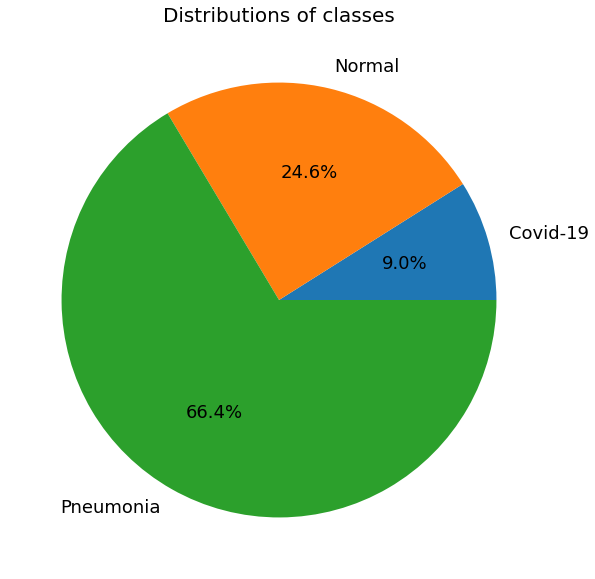

In [ ]:
percentage_of_data()

**Note :** If you are paying attention to the [Chest X-ray (Covid-19 & Pneumonia)](https://www.kaggle.com/prashant268/chest-xray-covid19-pneumonia) dataset, there are only xxx number of Covid19 training data, compared to the xxx number of the pneumonia training data. Thus, we definitely (but not mandatory) need to balance number of data between each class. The [COVID-19 Radiography Database](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) will gives us some more Covid19 x-ray data for the training.

### **2.4 Resampling the dataset**

In [ ]:
# create COVID-19 folder to store covid data from database
if not os.path.isdir('/content/covid_data'):
  os.mkdir('/content/covid_data')

if not os.path.isdir('/content/covid_data/COVID-19'):
  os.mkdir('/content/covid_data/COVID-19')

# build list of specific names of files that we will load it
files = []
for i in range(1143, 3567):
  files.append('COVID-'+ str(i) + '.png')


def load_covid_data(file_source, file_destination,files_name=files):
  """ this function move specific files 
      from COVID folder that included in database
      to COVID-19 folder"""
  get_files = os.listdir(file_source)
  for file in get_files:
    if file in files:
      shutil.move(file_source + file, file_destination)

def png_to_jpeg_converter(filePath='/content/covid_data/COVID-19'):

    inputPath = Path(filePath)
    inputFiles = inputPath.glob("**/*.png")
    outputPath = Path(filePath)
    for f in inputFiles:
        outputFile = outputPath / Path(f.stem + ".jpg")
        im = Image.open(f)
        im.save(outputFile)
        try:
            f.unlink()
        except OSError as e:
            print(f"Error:{ e.strerror}")

def move_data():

  train_path = '/content/output/train/COVID-19/'
  test_path = '/content/output/val/COVID-19/'
  for file in os.listdir(train_path):
     shutil.move(train_path + file, '/content/Data/train/COVID19')
  for file in os.listdir(test_path):
    shutil.move(test_path + file, '/content/Data/test/COVID19')
  try:
    shutil.rmtree('/content/output')
  except OSError as e:
      print("Error: %s : %s" % ('/content/output', e.strerror))

def remove_pne_data():

  train_files = os.listdir('/content/Data/train/PNEUMONIA')
  test_files = os.listdir('/content/Data/test/PNEUMONIA')
  train_files = random.sample(train_files, 1019)  # Pick 1019 random files
  test_files = random.sample(test_files, 254)  # Pick 254 random files

  for train_file in train_files:
    os.remove(os.path.join('/content/Data/train/PNEUMONIA', train_file))
  for test_file in test_files:
    os.remove(os.path.join('/content/Data/test/PNEUMONIA', test_file))

**Note:** you may notice that I loaded specific images from the COVID folder because I want to avoid duplicates from the same source, so if you want to understand that completely you should look for the sources of two datasets.

In [ ]:
remove_pne_data()
load_covid_data('/content/COVID-19_Radiography_Dataset/COVID/', '/content/covid_data/COVID-19',files)

png_to_jpeg_converter()

print('Number of files included in COVID-19 folder is : ',len(os.listdir('/content/covid_data/COVID-19')))

splitfolders.ratio('covid_data', output="output", seed=1337, ratio=(.8, 0.2))

move_data()

!rm -R /content/covid_data

Number of files included in COVID-19 folder is :  2424


Copying files: 2424 files [00:00, 8789.24 files/s]


In [ ]:
# create COVID-19 folder to store covid data from database
if not os.path.isdir('/content/normal_data'):
  os.mkdir('/content/normal_data')

if not os.path.isdir('/content/normal_data/Normal'):
  os.mkdir('/content/normal_data/Normal')

# build list of specific names of files that we will load it
Nfiles = []
for i in range(1, 8701):
  Nfiles.append('Normal-'+ str(i) + '.png')


def load_normal_data(file_source, file_destination, files_name=Nfiles):
  """ this function move specific files 
      from COVID folder that included in database
      to COVID-19 folder"""
  get_files = os.listdir(file_source)
  files = random.sample(Nfiles, k=1417)
  print(len(get_files))
  print(len(files))
  for file in get_files:
    if file in files:
      shutil.move(file_source + '/' +file, file_destination)
  print(len(os.listdir(file_destination)))


def move_normal_data():
  train_path = '/content/output/train/Normal/'
  print(len(os.listdir(train_path)))
  test_path = '/content/output/val/Normal/'
  print(len(os.listdir(test_path)))
  for file in os.listdir(train_path):
     shutil.move(train_path + file, '/content/Data/train/NORMAL')
  for file in os.listdir(test_path):
    shutil.move(test_path + file, '/content/Data/test/NORMAL')
  try:
    shutil.rmtree('/content/output')
  except OSError as e:
      print("Error: %s : %s" % ('/content/output', e.strerror))

In [ ]:
load_normal_data('/content/COVID-19_Radiography_Dataset/Normal', '/content/normal_data/Normal',Nfiles)

png_to_jpeg_converter('/content/normal_data/Normal')

print('Number of files included in Normal folder is : ',len(os.listdir('/content/normal_data/Normal')))

splitfolders.ratio('normal_data', output="output", seed=1337, ratio=(.8, 0.2))

move_normal_data()

!rm -R /content/normal_data

10192
1417
1417
Number of files included in Normal folder is :  1417


Copying files: 1417 files [00:00, 9130.03 files/s]

1133
284


In [ ]:
!rm -R Data/train/Normal
!rm -R Data/test/Normal
!rm -R Data/train/.ipynb_checkpoints
!rm -R Data/val/.ipynb_checkpoints
!rm -R Data/test/.ipynb_checkpoints

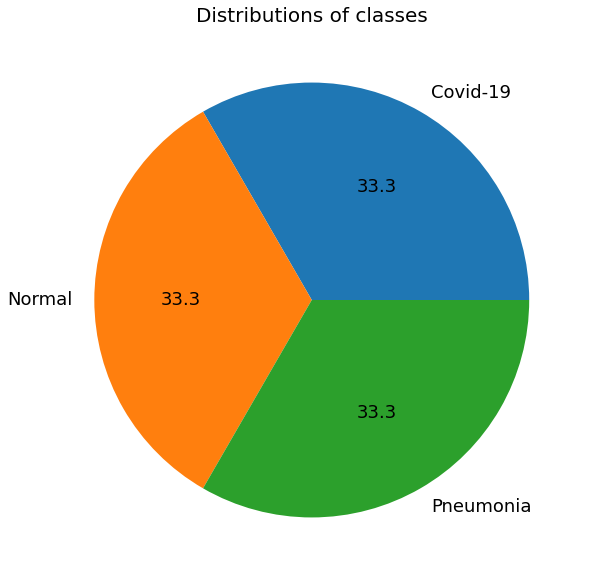

In [ ]:
percentage_of_data()

### **2.5 Split original test folder randomly and equaly between new test and validation folders**

Transform original train (80%) and test (20%) split in a new train (80%), validation (10%) and test (10%) split

In [ ]:
# Split original test folder randomly and equaly between test and validation (new) folders
if not os.path.isdir(os.path.join(DATA_PATH,'val')):
  os.mkdir(os.path.join(DATA_PATH,'val'))
  for subdir in categories:
    for root, dirs, files in os.walk(os.path.join(DATA_PATH, 'test/' +subdir)):
      size = len(files)
      migrate_index = random.sample(range(size), int(size/2))
      files_to_migrate = [files[i] for i in migrate_index]
      for file in files_to_migrate:
        file_path = os.path.join(DATA_PATH, 'test/' + subdir + '/' + file)
        new_dir = os.path.join(DATA_PATH, 'val/' + subdir)
        if not os.path.exists(new_dir):
          os.mkdir(new_dir)
        if not os.path.exists(os.path.join(new_dir, file)):
          a = shutil.move(file_path, new_dir)
else: print("Folder 'val' is already available and the split didn't happen")

Folder 'val' is already available and the split didn't happen


In [ ]:
shutil.make_archive('/content/drive/MyDrive/chest-xray-covid19-pneumonia_v2', 'zip', '/content/archive')

FileNotFoundError: ignored

In [ ]:
def show_dataset(data_path=DATA_PATH):
    df = pd.DataFrame(columns=['code'] + splits, index=categories)
    for row in categories:
      for col in splits:
        df.loc[row,col] = int(len(os.listdir(os.path.join(data_path, col+'/'+row))))
    df['total'] = df.sum(axis=1).astype(int)
    df.loc['TOTAL'] = df.sum(axis=0).astype(int)
    df['code'] = ['0','1','2','']
    return df
df_dataset = show_dataset()
df_dataset

,code,train,val,test,total
COVID19,0,2399,300,301,3000
NORMAL,1,2399,300,301,3000
PNEUMONIA,2,2399,300,301,3000
TOTAL,,7197,900,903,9000


## **3. Image enhancement techniques**

### **3.1 Histogram equalization (HE)**

<class 'numpy.ndarray'>


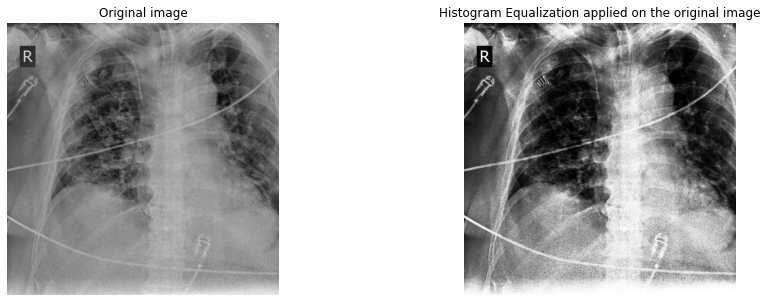

In [ ]:
img_example = cv2.imread('/content/Data/train/COVID19/COVID19(0).jpg',0)
img_example_hist = cv2.equalizeHist(img_example)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.imshow(img_example, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title("Original image")

ax2.imshow(img_example_hist, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title("Histogram Equalization applied on the original image")

fig.show()

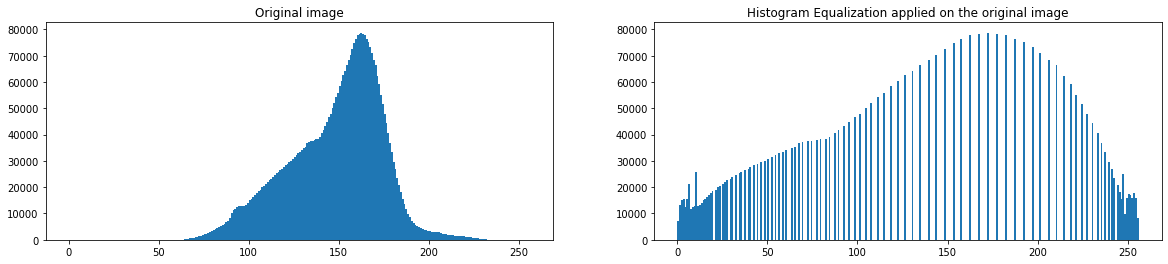

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))

ax1.hist(img_example.flatten(), 256, [0, 256])
ax1.set_title("Original image")

ax2.hist(img_example_hist.flatten(), 256, [0, 256])
ax2.set_title("Histogram Equalization applied on the original image")

fig.show()

In [ ]:
# Histogram equalization
HIST_DIR_PATH = '/content/Hist'

# create COVID-19 folder to store covid data from database
if not os.path.isdir('/content/Hist'):
  os.mkdir('/content/Hist')
  os.mkdir('/content/Hist/train')
  os.mkdir('/content/Hist/test')
  os.mkdir('/content/Hist/val')
  os.mkdir('/content/Hist/test/COVID19')
  os.mkdir('/content/Hist/test/NORMAL')
  os.mkdir('/content/Hist/test/PNEUMONIA')
  os.mkdir('/content/Hist/train/COVID19')
  os.mkdir('/content/Hist/train/NORMAL')
  os.mkdir('/content/Hist/train/PNEUMONIA')
  os.mkdir('/content/Hist/val/COVID19')
  os.mkdir('/content/Hist/val/NORMAL')
  os.mkdir('/content/Hist/val/PNEUMONIA')


def hist_equ(file_name):
    """ 
    Apply histogram equalization on image.

            Parameters:
                    file_name (str): The path of the image 

            Returns:
                    equ (ndarray): histogram equalized image  
    """
    # Read image file
    img = cv2.imread(file_name, 0)
    equ = cv2.equalizeHist(img)
    
    return equ

def traverse_and_apply_hist(data=DATA_PATH, new_dis=HIST_DIR_PATH):
    """ 
    Build new histogram equalized data from the source.

            Parameters:
                    data (str): The path of the source data 
                    new_dis (str): The path of the distination directory fro new data

            Returns:
                    None  
    """
    # Iterate through each image file
    for split in os.listdir(data):
        for category in os.listdir(os.path.join(data, split)):
            for file_name in os.listdir(os.path.join(data, split + '/' +category)):
                equ = hist_equ(os.path.join(data, split+ '/' + category + '/' +file_name))
                # Save file to new directory
                cv2.imwrite(os.path.join(new_dis, split+ '/' + category + '/' +file_name), equ)


In [ ]:
traverse_and_apply_hist()

In [ ]:
df = show_dataset(HIST_DIR_PATH)
df

,code,train,val,test,total
COVID19,0,2399,300,301,3000
NORMAL,1,2399,300,301,3000
PNEUMONIA,2,2399,300,301,3000
TOTAL,,7197,900,903,9000


### **3.2 Contrast limited adaptive histogram equalization (CLAHE)**

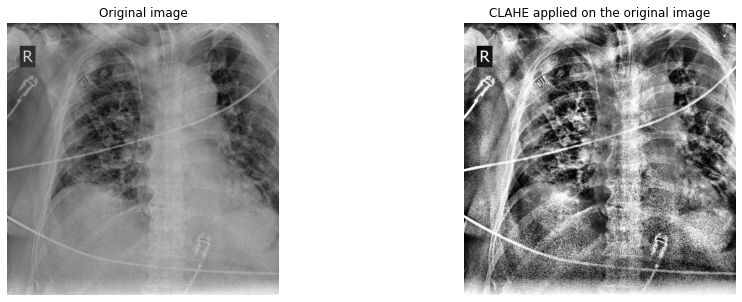

In [ ]:
clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8,8))

img_example = cv2.imread('/content/Data/train/COVID19/COVID19(0).jpg',0)
img_example_clahe = clahe.apply(img_example)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.imshow(img_example, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title("Original image")

ax2.imshow(img_example_clahe, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title("CLAHE applied on the original image")

fig.show()

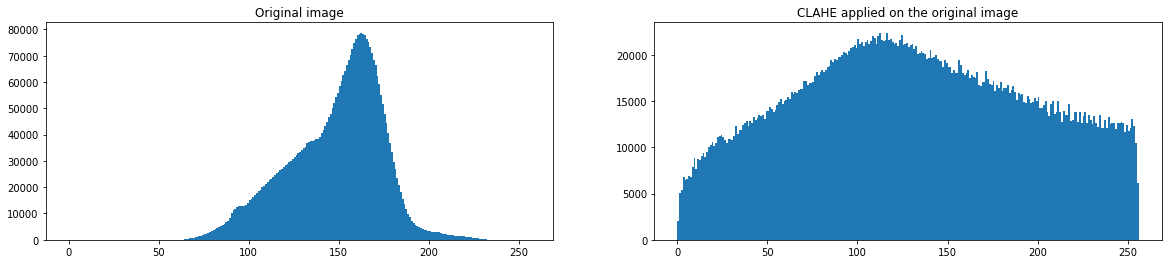

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))

ax1.hist(img_example.flatten(), 256, [0, 256])
ax1.set_title("Original image")

ax2.hist(img_example_clahe.flatten(), 256, [0, 256])
ax2.set_title("CLAHE applied on the original image")

fig.show()

In [ ]:
!rm -R /content/Adaptive

In [ ]:
if not os.path.isdir('/content/Adaptive'):
  os.mkdir('/content/Adaptive')
  os.mkdir('/content/Adaptive/train')
  os.mkdir('/content/Adaptive/test')
  os.mkdir('/content/Adaptive/val')
  os.mkdir('/content/Adaptive/test/COVID19')
  os.mkdir('/content/Adaptive/test/NORMAL')
  os.mkdir('/content/Adaptive/test/PNEUMONIA')
  os.mkdir('/content/Adaptive/train/COVID19')
  os.mkdir('/content/Adaptive/train/NORMAL')
  os.mkdir('/content/Adaptive/train/PNEUMONIA')
  os.mkdir('/content/Adaptive/val/COVID19')
  os.mkdir('/content/Adaptive/val/NORMAL')
  os.mkdir('/content/Adaptive/val/PNEUMONIA')

def adaptive_equ(file_name):
    """
      Apply Contrast limited adaptive histogram equalization on image.

              Parameters:
                      file_name (str): The path of the image 

              Returns:
                      equ (ndarray): Adaptive histogram equalized image  
    """
    # Read image file
    img = cv2.imread(file_name, 0)
    # create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(img)
    return cl

def traverse_and_apply_adaptive(data, new_dis):
    """ 
    Build new histogram equalized data from the source.

            Parameters:
                    data (str): The path of the source data 
                    new_dis (str): The path of the distination directory for new data

            Returns:
                    None  
    """
    # Iterate through each image file
    for split in os.listdir(data):
        for category in os.listdir(os.path.join(data, split)):
            for file_name in os.listdir(os.path.join(data, split + '/' +category)):
                clahe = adaptive_equ(os.path.join(data, split+ '/' + category + '/' +file_name))
                # Save file to new directory
                cv2.imwrite(os.path.join(new_dis, split+ '/' + category + '/' +file_name), clahe)

In [ ]:
traverse_and_apply_adaptive(DATA_PATH,'/content/Adaptive')

In [ ]:
df = show_dataset('/content/Adaptive')
df

,code,train,val,test,total
COVID19,0,2399,300,301,3000
NORMAL,1,2399,300,301,3000
PNEUMONIA,2,2399,300,301,3000
TOTAL,,7197,900,903,9000


[tutorial_py_histogram_equalization](https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html)

In [ ]:
# compress 2 datasets and store them in googal drive
shutil.make_archive('/content/drive/MyDrive/chest-xray-covid19-pneumonia_v2_hist', 'zip', '/content/hist')
shutil.make_archive('/content/drive/MyDrive/chest-xray-covid19-pneumonia_v2_adaptive', 'zip', '/content/archive')

'/content/drive/MyDrive/chest-xray-covid19-pneumonia_v2_adaptive.zip'

### **3.3 Image invert/complement**

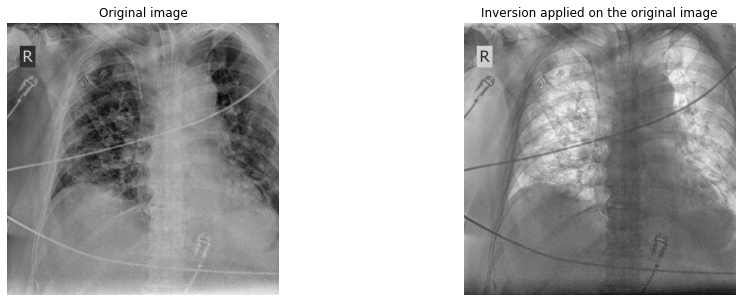

In [ ]:
img_example_3 = cv2.imread('/content/Data/train/COVID19/COVID19(0).jpg',0)
img_example_invert = cv2.bitwise_not(img_example_3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.imshow(img_example_3, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title("Original image")

ax2.imshow(img_example_invert, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title("Inversion applied on the original image")

fig.show()

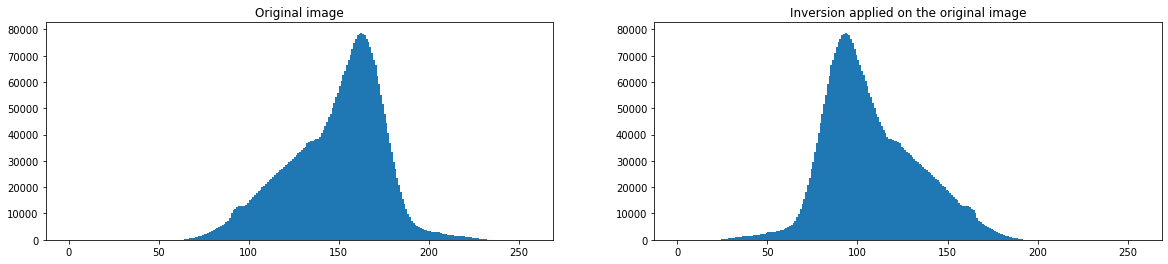

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))

ax1.hist(img_example_3.flatten(), 256, [0, 256])
ax1.set_title("Original image")

ax2.hist(img_example_invert.flatten(), 256, [0, 256])
ax2.set_title("Inversion applied on the original image")

fig.show()

In [ ]:
if not os.path.isdir('/content/Inverted'):
  os.mkdir('/content/Inverted')
  os.mkdir('/content/Inverted/train')
  os.mkdir('/content/Inverted/test')
  os.mkdir('/content/Inverted/val')
  os.mkdir('/content/Inverted/test/COVID19')
  os.mkdir('/content/Inverted/test/NORMAL')
  os.mkdir('/content/Inverted/test/PNEUMONIA')
  os.mkdir('/content/Inverted/train/COVID19')
  os.mkdir('/content/Inverted/train/NORMAL')
  os.mkdir('/content/Inverted/train/PNEUMONIA')
  os.mkdir('/content/Inverted/val/COVID19')
  os.mkdir('/content/Inverted/val/NORMAL')
  os.mkdir('/content/Inverted/val/PNEUMONIA')

def inversion(file_name):
    # Read image file
    img = cv2.imread(file_name, 0)
    inverted = cv2.bitwise_not(img)
    return inverted

def traverse_and_apply_invert(data, new_dis):
    # Iterate through each image file
    for split in os.listdir(data):
        for category in os.listdir(os.path.join(data, split)):
            for file_name in os.listdir(os.path.join(data, split + '/' +category)):
                inverted_img = inversion(os.path.join(data, split+ '/' + category + '/' +file_name))
                # Save file to new directory
                cv2.imwrite(os.path.join(new_dis, split+ '/' + category + '/' +file_name), inverted_img)

In [ ]:
traverse_and_apply_invert(DATA_PATH,'/content/Inverted')

In [ ]:
shutil.make_archive('/content/drive/MyDrive/chest-xray-covid19-pneumonia_v2_inverted', 'zip', '/content/archive')

'/content/drive/MyDrive/chest-xray-covid19-pneumonia_v2_inverted.zip'

### **3.4 Gamma correction**

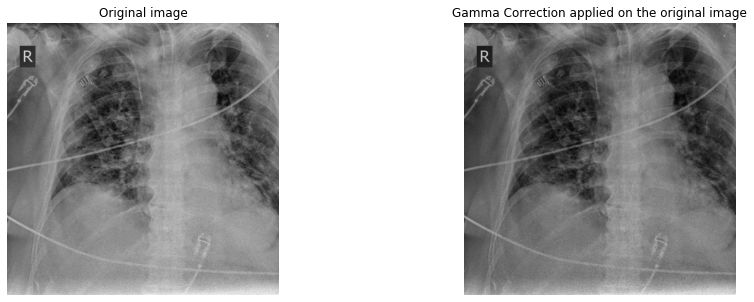

In [ ]:
def gammaCorrection(src, gamma=1.0):
    invGamma = 1 / gamma
 
    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)
 
    return cv2.LUT(src, table)


img_example_4 = cv2.imread('/content/Data/train/COVID19/COVID19(0).jpg',0)
img_example_gamma = gammaCorrection(img_example_4, 0.6)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.imshow(img_example_4, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title("Original image")

ax2.imshow(img_example_gamma, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title("Gamma Correction applied on the original image")

fig.show()

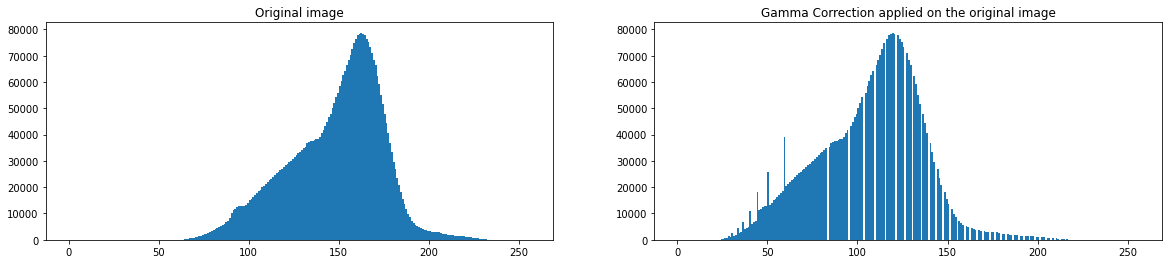

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))

ax1.hist(img_example_4.flatten(), 256, [0, 256])
ax1.set_title("Original image")

ax2.hist(img_example_gamma.flatten(), 256, [0, 256])
ax2.set_title("Gamma Correction applied on the original image")

fig.show()

## **4. Image augmentation and load data**

Use python's transform module to perform following image augmentation steps:

1.   Resize the x-ray image to the image of shape(224, 224) uniformly
2.   Apply centercrop function to crop the center part of the image of shape (224, 224). For inception use size of 299
1.   Convert image to tensor
2.   Load train and test data using ImageFolder function
5.   Concatenate the train and test dataset

In [ ]:
!rm -R Data/train/.ipynb_checkpoints
!rm -R Data/val/.ipynb_checkpoints
!rm -R Data/test/.ipynb_checkpoints

In [ ]:
def load_data(data_path=DATA_PATH, num_workers=num_workers):
    transform_dict = {
        'model': transforms.Compose(
                                    [transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     ])}
    train_data = datasets.ImageFolder(root=data_path + '/train', transform=transform_dict['model'])
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_data = datasets.ImageFolder(root=data_path + '/val', transform=transform_dict['model'])
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_data = datasets.ImageFolder(root=data_path + '/test', transform=transform_dict['model'])
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_data, train_loader, val_data, val_loader, test_data, test_loader

train_data, train_loader, val_data, val_loader, test_data, test_loader = load_data()
dataset = torch.utils.data.ConcatDataset([train_data, val_data, test_data])

for more information about ImageFolder & DataLoader you should see [Datasets and Dataloaders in pytorch](https://colab.research.google.com/github/davidbau/how-to-read-pytorch/blob/master/notebooks/5-Pytorch-Dataloader.ipynb#scrollTo=H-I-P4P_rCEE) colab notebook.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'You are using {device}')

You are using cuda


## **5. Visualization**

Visualize a batch of images representing train dataset

**histogram equalization**

Class: COVID19


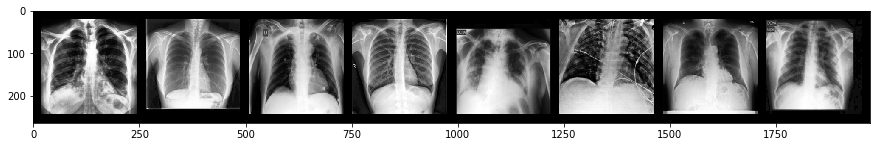

Class: NORMAL


<Figure size 432x288 with 0 Axes>

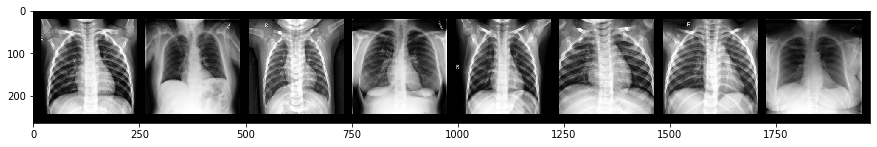

Class: PNEUMONIA


<Figure size 432x288 with 0 Axes>

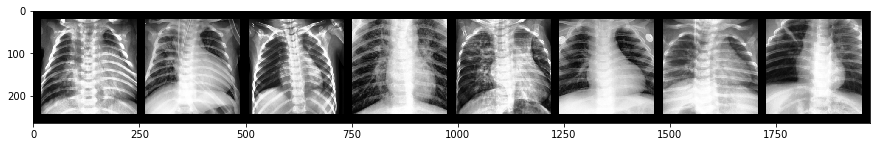

<Figure size 432x288 with 0 Axes>

In [ ]:
def show_batch_images(datasets):
  n_images, scale = 8, 3
  data_loader = torch.utils.data.DataLoader(dataset, batch_size=25*n_images, shuffle=True)
  images, labels = next(iter(data_loader))
  for i in range(len(categories)):
    print(f'Class: {categories[i]}')
    images_category = images[labels==i][:n_images]
    grid = torchvision.utils.make_grid(images_category, padding=20)
    npgrid = grid.cpu().numpy()
    plt.figure(figsize=(40*scale/n_images, 20*scale/n_images))
    plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
    plt.show()
    plt.savefig('x-ray[i].pdf')  
    #plt.savefig("viz1.png", bbox_inches='tight')

show_batch_images(train_data)

**adaptive histogram equalization (defualt values[40.0,(8,8)])**

Class: COVID19


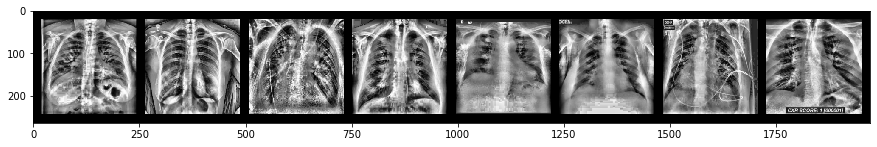

Class: NORMAL


<Figure size 432x288 with 0 Axes>

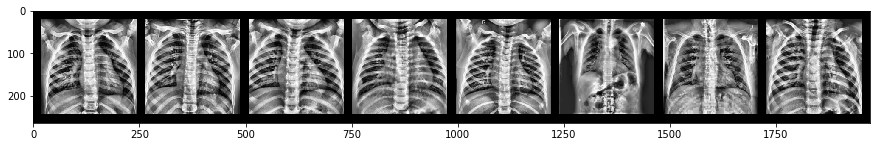

Class: PNEUMONIA


<Figure size 432x288 with 0 Axes>

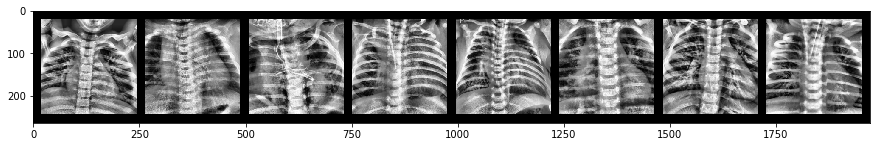

<Figure size 432x288 with 0 Axes>

In [ ]:
def show_batch_images(datasets):
  n_images, scale = 8, 3
  data_loader = torch.utils.data.DataLoader(dataset, batch_size=25*n_images, shuffle=True)
  images, labels = next(iter(data_loader))
  for i in range(len(categories)):
    print(f'Class: {categories[i]}')
    images_category = images[labels==i][:n_images]
    grid = torchvision.utils.make_grid(images_category, padding=20)
    npgrid = grid.cpu().numpy()
    plt.figure(figsize=(40*scale/n_images, 20*scale/n_images))
    plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
    plt.show()
    plt.savefig('x-ray[i].pdf')  
    #plt.savefig("viz1.png", bbox_inches='tight')

show_batch_images(train_data)

**adaptive histogram equalization (clipLimit=2.0, tileGridSize=(8,8))**

Class: COVID19


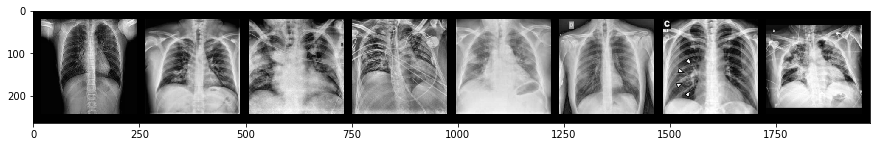

Class: NORMAL


<Figure size 432x288 with 0 Axes>

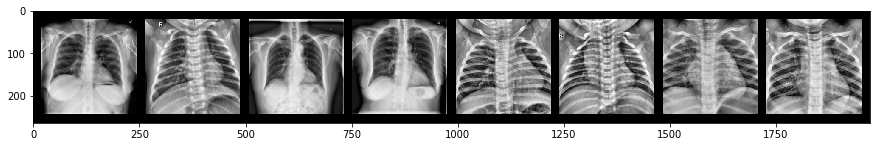

Class: PNEUMONIA


<Figure size 432x288 with 0 Axes>

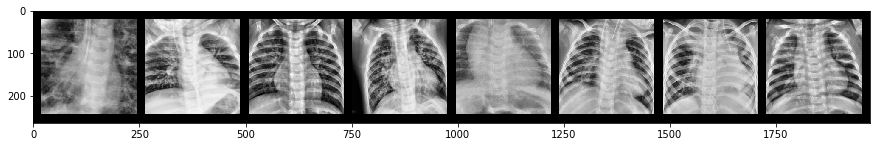

<Figure size 432x288 with 0 Axes>

In [ ]:
def show_batch_images(datasets):
  n_images, scale = 8, 3
  data_loader = torch.utils.data.DataLoader(dataset, batch_size=25*n_images, shuffle=True)
  images, labels = next(iter(data_loader))
  for i in range(len(categories)):
    print(f'Class: {categories[i]}')
    images_category = images[labels==i][:n_images]
    grid = torchvision.utils.make_grid(images_category, padding=20)
    npgrid = grid.cpu().numpy()
    plt.figure(figsize=(40*scale/n_images, 20*scale/n_images))
    plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
    plt.show()
    plt.savefig('x-ray[i].pdf')  
    #plt.savefig("viz1.png", bbox_inches='tight')

show_batch_images(train_data)

Class: COVID19


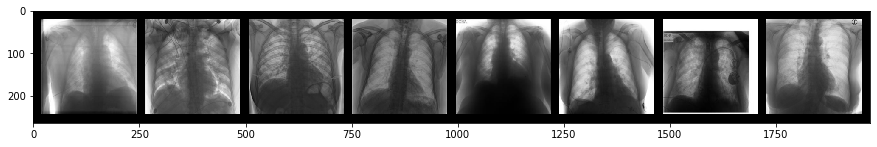

Class: NORMAL


<Figure size 432x288 with 0 Axes>

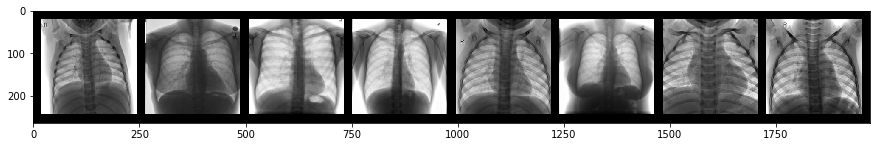

Class: PNEUMONIA


<Figure size 432x288 with 0 Axes>

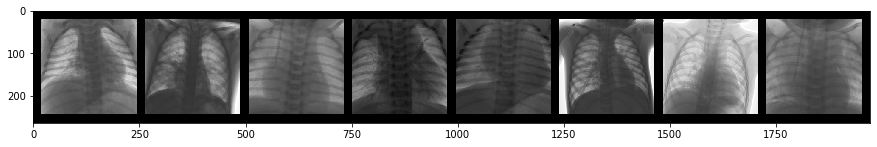

<Figure size 432x288 with 0 Axes>

In [ ]:
def show_batch_images(datasets):
  n_images, scale = 8, 3
  data_loader = torch.utils.data.DataLoader(dataset, batch_size=25*n_images, shuffle=True)
  images, labels = next(iter(data_loader))
  for i in range(len(categories)):
    print(f'Class: {categories[i]}')
    images_category = images[labels==i][:n_images]
    grid = torchvision.utils.make_grid(images_category, padding=20)
    npgrid = grid.cpu().numpy()
    plt.figure(figsize=(40*scale/n_images, 20*scale/n_images))
    plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
    plt.show()
    plt.savefig('x-ray[i].pdf')  
    #plt.savefig("viz1.png", bbox_inches='tight')

show_batch_images(train_data)

## **6. Define the supporting modules**

### **6.1 Calculate metrics, plot loss graph and create confusion matrix**

In [ ]:
def calc_metrics(predictions, actuals, row):
    df = pd.DataFrame(columns =metrics)
    Y_pred = np.concatenate(predictions, axis=0)
    Y_test = np.concatenate(actuals, axis=0)
    df.loc[row, 'Accuracy'] = accuracy_score(Y_test, Y_pred)
    df.loc[row, 'Precision'] = precision_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'Recall'] = recall_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'F1-score'] = f1_score(Y_test, Y_pred, average="macro")
    return df

def create_confusion_matrix(preds, y_test):
    ylist, predlist = [], []
    for pred in preds:
        for item in pred:
            predlist.append(int(item))
    for y in y_test:
        for item in y:
            ylist.append(int(item))
    data_dict = {'y_Actual':    ylist, 'y_Predicted': predlist}
    df = pd.DataFrame(data_dict, columns=['y_Actual','y_Predicted'])
    cm = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['ACTUAL'], colnames=['PREDICTED'])
    return cm

def plot_train_val_losses(df):
    df2 = pd.melt(df, id_vars=['epoch'], value_vars=['train', 'val'], var_name='process', value_name='loss')
    sns.lineplot(x = "epoch", y = "loss", data = df2, hue = "process",
                style = "process", palette = "hot", dashes = False, 
                markers = ["o", "<"],  legend="brief").set_title("Train and Validation Losses by Epoch")
    plt.show()

### **6.2 Create the train, evaluation and test modules**

In [ ]:
def reset_weights(m):
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

def calc_pred_actuals(model, loader):
    predictions, actuals = [], []
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            Y_pred_orig = model(data)
            _, Y_pred_tag = torch.max(Y_pred_orig, dim = 1)
            Y_pred_tag = Y_pred_tag.detach().cpu().numpy()
            Y_pred_tag = Y_pred_tag.reshape(len(Y_pred_tag), 1).astype('int8')
            Y_test = target.detach().cpu().numpy()
            Y_test = Y_test.reshape(len(Y_test), 1).astype('int8')
            predictions.append(Y_pred_tag)
            actuals.append(Y_test)
    return predictions, actuals

def train_val_model(model):
    t_start = time.time()
    global best_val_model
    global best_val_loss
    best_val_loss = 1
    global best_val_epoch
    best_val_epoch = 0
    df = pd.DataFrame(columns = ['model_name', 'epoch', 'train', 'val'])
    print(f"Training model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and max of {n_epochs} epochs, and validating with {df_dataset.loc['TOTAL', 'val']} samples\n")
    train_size, val_size = len(train_loader), len(val_loader)
    #PATH = '/content/drive/MyDrive/check_p.tar'
    # checkpoint = torch.load(PATH)
    # model.load_state_dict(checkpoint['model_state_dict'])
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # epoch = checkpoint['epoch']
    # loss = checkpoint['loss']
    for epoch in range(1, n_epochs+1):
        # Beginning of training step
        t0 = time.time()
        model.train()
        train_loss, val_loss = 0.0, 0.0
        for i, (data, target) in enumerate(train_loader):
            target = target.to(device)
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().numpy()
        # Beginning of evaluation step
        model.eval()
        for j, (data, target) in enumerate(val_loader):
            target = target.to(device)
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.detach().cpu().numpy()
        print(f"Epoch {epoch}:\t train loss={train_loss/train_size:.5f} \t val loss={val_loss/val_size:.5f} \t time={(time.time() - t0):.2f}s")
        df.loc[len(df)] = [model_name, epoch, train_loss/train_size, val_loss/val_size]
        #if epoch >= best_val_epoch + 15:
            #break
        if use_scheduler: scheduler.step(val_loss/val_size)   # Optional to use scheduler for dynamic learning rate
        # torch.save({
        #     'epoch': epoch,
        #     'model_state_dict': model.state_dict(),
        #     'optimizer_state_dict': optimizer.state_dict(),
        #     'loss': loss,
        #     'val_loss':val_loss
        #     }, PATH)
        # wandb.log({"train loss": (train_loss/train_size), "val loss": (val_loss/val_size)})
    print(f"Best model has val loss={best_val_loss:.5f} for {best_val_epoch} epochs")
    print(f"Total time training and evaluating: {(time.time()-t_start):.2f}s")
    return model, df

def train_val_model_kfold(model, train_loader_kfold):
    t_start = time.time()
    df = pd.DataFrame(columns = ['model_name', 'epoch', 'train'])
    print(f"Training model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and max of {n_epochs} epochs")
    train_size = len(train_loader_kfold)
    for epoch in range(1, n_epochs+1):
        # Beginning of training step
        t0 = time.time()
        #model.train()
        train_loss = 0.0
        for i, (data, target) in enumerate(train_loader_kfold):
            target = target.to(device)
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().numpy()
        print(f"Epoch {epoch}:\t train loss={train_loss/train_size:.5f} \t time={(time.time() - t0):.2f}s")
        df.loc[len(df)] = [model_name, epoch, train_loss/train_size]
    print(f"Total time training and evaluating: {(time.time()-t_start):.2f}s")
    return model, df

def accuracy_model(model, loader):
    model.eval()
    print(f"Testing the model {model_name} with {df_dataset.loc['TOTAL', 'test']} samples \n")   
    predictions, actuals = calc_pred_actuals(model, loader)
    conf_matrix = create_confusion_matrix(predictions, actuals)
    df_test = calc_metrics(predictions, actuals, 'Test Results').astype(float)
    print(df_test)
    return df_test, conf_matrix

## **7. Model Development: Using our own CNN model**

### **7.1 CNN architecture with three convolutional layers and two linear layers**

In [ ]:
layer = [128, 128, 256, 256, 3]

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, layer[0], 3, padding=1)
        self.bn1 = nn.BatchNorm2d(layer[0])
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.conv2 = nn.Conv2d(layer[0], layer[1], 3, padding=1)
        self.bn2 = nn.BatchNorm2d(layer[1])
        self.conv3 = nn.Conv2d(layer[1], layer[2], 3, padding=1)
        self.bn3 = nn.BatchNorm2d(layer[2])
        self.conv4 = nn.Conv2d(layer[1], layer[2], 3, padding=1)
        self.bn4 = nn.BatchNorm2d(layer[2])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear1 = nn.Linear(14 * 14 * layer[2], layer[3])
        self.linear2 = nn.Linear(layer[3], layer[4])
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool2(self.relu(self.bn3(self.conv3(x))))
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return x

NameError: ignored

### **7.2 Train the model with variable number of epochs and learning rate**

- Learning rate starts with 1e-3 and decrease 20% when validation loss didn't progress
- Training process stop if validation loss didn't increase after 15 epochs

In [ ]:
np.random.seed(seed)
torch.manual_seed(seed)
net = Net().to(device)
model_name = 'DLH_COVID'
n_epochs = 20
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

# Optional: use_scheduler = True will use dynamic values of learning_rate
use_scheduler = True  # Set True if using scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=3, threshold = 0.001,
                                                  verbose=True, min_lr = 1e-5, threshold_mode = 'abs')
our_model, df_epochs = train_val_model(net)

NameError: ignored

### **7.3  Plot train and validation losses of our model**

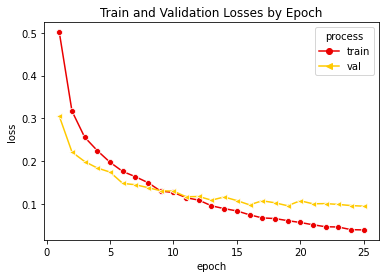

In [ ]:
plot_train_val_losses(df_epochs)

### **7.5 Calculate metrics of best evaluated model using test dataset**



In [ ]:
test_results, conf_matrix_test = accuracy_model(our_model, test_loader)

Testing the model DLH_COVID with 903 samples 

              Accuracy  Precision    Recall  F1-score
Test Results  0.890365   0.911691  0.890365  0.891421


### **7.6 Show confusion matrix using the test dataset**

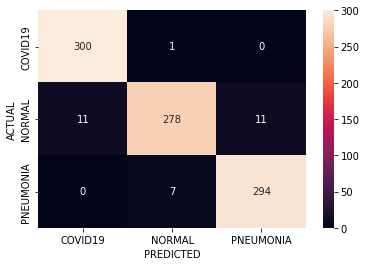

In [ ]:
_ = sns.heatmap(conf_matrix_test, annot=True, fmt='g', xticklabels=categories, yticklabels=categories)

### **7.7 Save final model to be deployed as a web application**

In [ ]:
torch.save(our_model.state_dict(), os.path.join(model_path, 'model_21e_1e-2_96.7_hist_v2.pth'))

## **9. Model Development: using pre-trained modules**
### 9.1 Load pre-trained model
For this image classification exercise, we leveraged 8 different pre-trained models as a part of transfer learning approach:

1. Resnet18, Resnet34, Resnet50 and Resnet101
2. VGG16 and VGG19
3. EfficientNet
4. Inception

All the models have been loaded from the torchvision module. (https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)

By default, when we load a pretrained model all of the parameters have .requires_grad=True. But we trained only the last layer hence we set the attribute requires_grad=False.


In [ ]:
pip install --upgrade efficientnet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def initialize_model(model_name, num_classes, use_pretrained=True):
  
    if model_name == "resnet18":
        model_ft = models.resnet18(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = False
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    
    elif model_name == "resnet34":
        model_ft = models.resnet34(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = False
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    
    elif model_name == "resnet50":
        model_ft = models.resnet50(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = False
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    
    elif model_name == "resnet101":
        model_ft = models.resnet101(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = False
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == "vgg16":
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = False
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    
    elif model_name == "vgg19":
        model_ft = models.vgg19_bn(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = False
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    
    elif model_name == "EfficientNet":
        from efficientnet_pytorch import EfficientNet
        model_ft = EfficientNet.from_pretrained('efficientnet-b7',num_classes=num_classes)
    elif model_name == "inception":
        model_ft = models.inception_v3(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = False
            #param.aux_logits = False    
        #num_ftrs = model_ft.fc.in_features
        #model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        model_ft.aux_logits = False
    
    else:
        print("Invalid model name, exiting...")
        exit()
    
    model_ft.to(device)
    return model_ft

### **9.2 Pre-trained model example: VGG19**

Pass model name as parameter to run pre-trained model of your preference.

In [ ]:
vgg_model = initialize_model("vgg19", num_classes,   use_pretrained=True)

# resnet18_model = initialize_model("resnet18", num_classes, use_pretrained=True)
# resnet34_model = initialize_model("resnet34", num_classes, use_pretrained=True)
# resnet50_model = initialize_model("resnet50", num_classes, use_pretrained=True)
# resnet101_model = initialize_model("resnet101", num_classes, use_pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

### **9.3 Train the INCEPTION model**

In [ ]:
np.random.seed(seed)
torch.manual_seed(seed)
model_name = 'vgg19'
n_epochs = 20
learning_rate = 1e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg_model.parameters(), lr=learning_rate)
use_scheduler = False   # Set True if using scheduler
pretrained_model, df_inception_epochs = train_val_model(vgg_model)

Training model vgg19 with 7197 samples and max of 20 epochs, and validating with 900 samples

Epoch 1:	 train loss=0.50104 	 val loss=0.30923 	 time=103.79s
Epoch 2:	 train loss=0.38627 	 val loss=0.27914 	 time=103.00s
Epoch 3:	 train loss=0.35104 	 val loss=0.25646 	 time=102.33s
Epoch 4:	 train loss=0.34615 	 val loss=0.24925 	 time=100.69s
Epoch 5:	 train loss=0.33412 	 val loss=0.25801 	 time=105.85s


### **9.4  Plot train and validation losses of the VGG19 model**

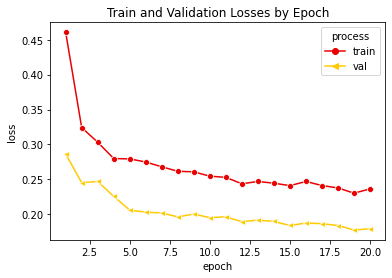

In [ ]:
plot_train_val_losses(df_inception_epochs)

### **9.5 Calculate metrics of best INCEPTION eval model using test dataset**

In [ ]:
test_inception_results, conf_inception_matrix_test = accuracy_model(pretrained_model, test_loader)

Testing the model vgg19 with 902 samples 

              Accuracy  Precision    Recall  F1-score
Test Results   0.95122   0.951146  0.951192  0.951115


### **9.6 Show confusion matrix for test dataset**

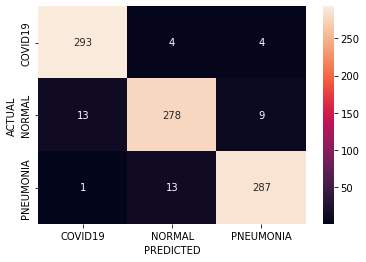

In [ ]:
_ = sns.heatmap(conf_inception_matrix_test, annot=True, fmt='g', xticklabels=categories, yticklabels=categories)

In [ ]:
len(dataset)

8905

In [ ]:
pip install --upgrade efficientnet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# prints currently alive Tensors and Variables
import torch
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except:
        pass

<class 'torch.Tensor'> torch.Size([32])
<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([32])
<class 'torch.Tensor'> torch.Size([32])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([32])
<class 'torch.Tensor'> torch.Size([32])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([32])
<class 'torch.Tensor'> torch.Size([32])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([32])
<class 'torch.Tensor'> torch.Size([32])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([32])
<class 'torch.Tensor'> torch.Size([32])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([32])
<class 'torch.Tensor'> torch.Size([32])
<

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: astor.all_symbols is deprecated.  Please use astor.symbol_data.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: astor.treewalk is deprecated.  Please use astor.tree_walk.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: astor.codegen is deprecated.  Please use astor.code_gen.
  


<class 'torch.nn.parameter.Parameter'> torch.Size([64, 3, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 1, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([16, 64, 1, 1])
<class 'torch.nn.parameter.Parameter'> torch.Size([16])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 16, 1, 1])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([32, 64, 1, 1])
<class 'torch.nn.parameter.Parameter'> torch.Size([32])
<class 'torch.nn.parameter.Parameter'> torch.Size([32])
<class 'torch.nn.parameter.Parameter'> torch.Size([32, 1, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([32])
<class 'torch.nn.parameter.Parameter'> torch.Size([32])
<class 'torch.nn.parameter.Parameter'> torch.Si

/usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py:182: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  "torch.distributed.reduce_op is deprecated, please use "


In [ ]:
#Pre-trained model
EfficientNet_model = initialize_model("EfficientNet", num_classes, use_pretrained=True)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b7


In [ ]:
#train EfficientNet model
np.random.seed(seed)
torch.manual_seed(seed)
model_name = 'EfficientNet'
n_epochs = 20
learning_rate = 1e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(EfficientNet_model.parameters(), lr=learning_rate)
use_scheduler = False   # Set True if using scheduler
pretrained_model, df_EfficientNet_epochs = train_val_model(EfficientNet_model)

Training model EfficientNet with 7197 samples and max of 20 epochs, and validating with 900 samples



RuntimeError: ignored